# Comparación de estrategias de inversión en BTC

## Ingesta

In [3]:
from pyspark.sql import SparkSession

# Creo la sesión de Spark con soporte para S3 en el cluster de Spark

spark = SparkSession.builder \
    .appName("Jupyter-Inversion-BTC") \
    .master("spark://spark-master:7077") \
    .config("spark.driver.memory", "1g") \
    .config("spark.executor.memory", "1g") \
    .config("spark.hadoop.fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider") \
    .config("spark.hadoop.fs.s3a.endpoint", "http://172.18.0.6:4566") \
    .config("spark.hadoop.fs.s3a.access.key", "test") \
    .config("spark.hadoop.fs.s3a.secret.key", "test") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .getOrCreate()


# Para ejecución en local con soporte para S3

#spark = SparkSession.builder \
#    .appName("Bitcoin-Ingestion") \
#    .config("spark.hadoop.fs.s3a.endpoint", "http://172.18.0.6:4566") \
#    .config("spark.hadoop.fs.s3a.access.key", "test") \
#    .config("spark.hadoop.fs.s3a.secret.key", "test") \
#    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
#    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
#    .getOrCreate()

In [2]:
# Verifico que el master está apuntandoselos al cluster, y no a local

spark.sparkContext.master

'spark://spark-master:7077'

In [16]:
pip install yfinance pyarrow

Note: you may need to restart the kernel to use updated packages.


In [4]:
import yfinance as yf
import pandas as pd

# Descargo datos históricos de Bitcoin
btc_data = yf.download("BTC-USD", start="2018-01-01", end="2025-01-01", interval="1d")

# Voy a usar PySpark en lugar de Pandas para aprovechar el clúster. Convierto Pandas DataFrame a PySpark DataFrame
btc_df = spark.createDataFrame(btc_data.reset_index())

# Renombro las columnas para que sean compatibles con Spark, ya que las descarga como una tupla
btc_df = btc_df.withColumnRenamed("('Date', '')", "Date") \
       .withColumnRenamed("('Open', 'BTC-USD')", "Open") \
       .withColumnRenamed("('High', 'BTC-USD')", "High") \
       .withColumnRenamed("('Low', 'BTC-USD')", "Low") \
       .withColumnRenamed("('Close', 'BTC-USD')", "Close") \
       .withColumnRenamed("('Volume', 'BTC-USD')", "Volume")

# Defino la ruta a mi S3 de LocalStack
s3_path = "s3a://my-bucket/tables/btc_prices/"

# Guardo en S3 en formato Parquet para reducir el tamaño de los archivos y mejorar la velocidad de lectura.
btc_df.write.mode("overwrite").parquet(s3_path)

print(f"✅ Datos de Bitcoin guardados en {s3_path}")


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


✅ Datos de Bitcoin guardados en s3a://my-bucket/tables/btc_prices/


## Análisis y limpieza de los datos

In [5]:
from pyspark.sql import SparkSession

# Leo los datos desde S3 en formato Parquet
s3_path = "s3a://my-bucket/tables/btc_prices/"

df = spark.read.parquet(s3_path)

# Muestro la estructura
df.printSchema()
df.show(5)

root
 |-- Date: timestamp (nullable = true)
 |-- Close: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Open: double (nullable = true)
 |-- Volume: long (nullable = true)

+-------------------+----------------+----------------+----------------+----------------+-----------+
|               Date|           Close|            High|             Low|            Open|     Volume|
+-------------------+----------------+----------------+----------------+----------------+-----------+
|2020-10-21 00:00:00| 12823.689453125|  13184.56640625|11900.9287109375|11913.0771484375|43414712626|
|2020-10-22 00:00:00|12965.8916015625|     13161.59375|     12717.09375|12801.6357421875|34729759598|
|2020-10-23 00:00:00|   12931.5390625|13015.9619140625|12752.6474609375| 12971.548828125|28974975003|
|2020-10-24 00:00:00|      13108.0625|  13145.06640625|12885.7470703125|  12931.57421875|24542317940|
|2020-10-25 00:00:00| 13031.173828125|  13329.18359375|12910.

In [6]:
from pyspark.sql.functions import min, max

# Obtengo la fecha de los primeros y últimos datos
df.select(min("Date").alias("Fecha mínima"), max("Date").alias("Fecha máxima")).show()

+-------------------+-------------------+
|       Fecha mínima|       Fecha máxima|
+-------------------+-------------------+
|2018-01-01 00:00:00|2024-12-31 00:00:00|
+-------------------+-------------------+



In [7]:
# Obtengo estadíticas de los datos
df.describe(["Open", "High", "Low", "Close", "Volume"]).show()


+-------+------------------+------------------+------------------+------------------+--------------------+
|summary|              Open|              High|               Low|             Close|              Volume|
+-------+------------------+------------------+------------------+------------------+--------------------+
|  count|              2557|              2557|              2557|              2557|                2557|
|   mean|28056.369437947607|28677.221780609143|27406.235937328136|28085.636904170842|2.696023827837622E10|
| stddev|22105.805882508987|22595.357591167784| 21608.67192516129| 22139.59408844191|1.965527435234371E10|
|    min| 3236.274658203125|   3275.3779296875| 3191.303466796875|     3236.76171875|          2923670016|
|    max|     106147.296875|    108268.4453125|     105291.734375|    106140.6015625|        350967941479|
+-------+------------------+------------------+------------------+------------------+--------------------+



In [8]:
# Imprimo el número de registros
print(f"Total de registros: {df.count()}")

Total de registros: 2557


In [9]:
# Día con el precio de cierre más alto
df.orderBy(df["Close"].desc()).select("Date", "Close").limit(1).show()

+-------------------+--------------+
|               Date|         Close|
+-------------------+--------------+
|2024-12-17 00:00:00|106140.6015625|
+-------------------+--------------+



In [10]:
# Día con el precio de cierre más bajo
df.orderBy(df["Close"].asc()).select("Date", "Close").limit(1).show()

+-------------------+-------------+
|               Date|        Close|
+-------------------+-------------+
|2018-12-15 00:00:00|3236.76171875|
+-------------------+-------------+



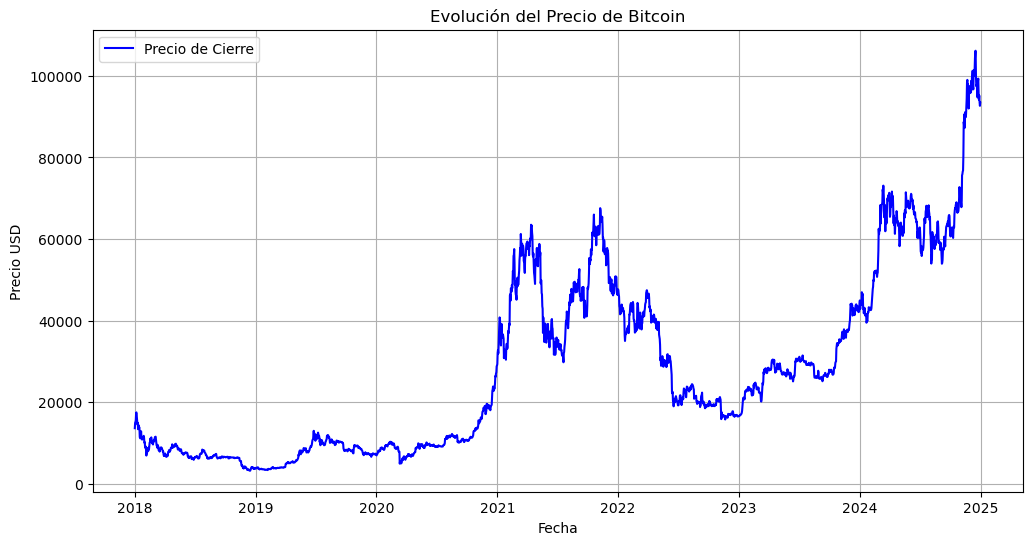

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Convierto el df de Spark a Pandas para graficar
btc_pandas = df.select("Date", "Close").orderBy("Date").toPandas() # Ordeno por fecha, parece que estaban desordenados y por eso algunos datos salian mal en el gráfico 
btc_pandas["Date"] = pd.to_datetime(btc_pandas["Date"])  # Convierto a formato fecha

# Gráfico
plt.figure(figsize=(12, 6))
plt.plot(btc_pandas["Date"], btc_pandas["Close"], label="Precio de Cierre", color="blue")
plt.xlabel("Fecha")
plt.ylabel("Precio USD")
plt.title("Evolución del Precio de Bitcoin")
plt.legend()
plt.grid()
plt.show()


In [12]:
from pyspark.sql.functions import count

# Compruebo si hay registros duplicados por fecha, o solamente hay un dato por día 
df_dupes = df.groupBy("Date").agg(count("*").alias("count")).filter("count > 1")

# Muestro solo las fechas con datos duplicados
df_dupes.show()


+----+-----+
|Date|count|
+----+-----+
+----+-----+



# Procesado

In [6]:
# Leo los datos desde S3 en formato Parquet
s3_path = "s3a://my-bucket/tables/btc_prices/"
df = spark.read.parquet(s3_path)

# Convierto la columna de fecha al tipo correcto y ordeno
from pyspark.sql.functions import to_date

df = df.withColumn("Date", to_date(df["Date"])).orderBy("Date")
df.printSchema()
df.show(5)

root
 |-- Date: date (nullable = true)
 |-- Close: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Open: double (nullable = true)
 |-- Volume: long (nullable = true)

+----------+----------------+----------------+----------------+----------------+-----------+
|      Date|           Close|            High|             Low|            Open|     Volume|
+----------+----------------+----------------+----------------+----------------+-----------+
|2018-01-01|13657.2001953125|14112.2001953125|13154.7001953125|14112.2001953125|10291200000|
|2018-01-02| 14982.099609375| 15444.599609375| 13163.599609375|         13625.0|16846600192|
|2018-01-03|         15201.0|15572.7998046875|         14844.5|14978.2001953125|16871900160|
|2018-01-04|15599.2001953125|15739.7001953125|14522.2001953125|15270.7001953125|21783199744|
|2018-01-05|         17429.5|  17705.19921875|15202.7998046875|15477.2001953125|23840899072|
+----------+----------------+-------

## Cálculo SMA (Media Móvil Simple)

In [7]:
from pyspark.sql.window import Window
from pyspark.sql.functions import avg

# Defino las ventanas temporales sobre las que voy a calcular la media (14, 50 y 200 días)
window_spec_14 = Window().orderBy("Date").rowsBetween(-13, 0)
window_spec_50 = Window().orderBy("Date").rowsBetween(-49, 0)
window_spec_200 = Window().orderBy("Date").rowsBetween(-199, 0)


# Calculo las medias sobre las ventanas temporales
df = df.withColumn("SMA_14", avg("Close").over(window_spec_14))
df = df.withColumn("SMA_50", avg("Close").over(window_spec_50))
df = df.withColumn("SMA_200", avg("Close").over(window_spec_200))

df.select("Date", "Close", "High", "Low", "Open", "Volume", "SMA_14", "SMA_50", "SMA_200").show(5)

+----------+----------------+----------------+----------------+----------------+-----------+------------------+------------------+------------------+
|      Date|           Close|            High|             Low|            Open|     Volume|            SMA_14|            SMA_50|           SMA_200|
+----------+----------------+----------------+----------------+----------------+-----------+------------------+------------------+------------------+
|2018-01-01|13657.2001953125|14112.2001953125|13154.7001953125|14112.2001953125|10291200000|  13657.2001953125|  13657.2001953125|  13657.2001953125|
|2018-01-02| 14982.099609375| 15444.599609375| 13163.599609375|         13625.0|16846600192| 14319.64990234375| 14319.64990234375| 14319.64990234375|
|2018-01-03|         15201.0|15572.7998046875|         14844.5|14978.2001953125|16871900160|14613.433268229166|14613.433268229166|14613.433268229166|
|2018-01-04|15599.2001953125|15739.7001953125|14522.2001953125|15270.7001953125|21783199744|        

## Cálculo RSI (Índice de Fuerza Relativa)

In [8]:
from pyspark.sql.functions import lag, when, col, avg, lit
from pyspark.sql.window import Window

# Ordeno por fecha
window_spec = Window().orderBy("Date")

# Calculo el cambio diario en el precio
df = df.withColumn("Change", col("Close") - lag("Close", 1).over(window_spec))

# Calculo las ganancias y pérdidas
df = df.withColumn("Gain", when(col("Change") > 0, col("Change")).otherwise(0))
df = df.withColumn("Loss", when(col("Change") < 0, -col("Change")).otherwise(0))

# Creo una ventana temporal para calcular el promedio de 14 días
window_14 = Window().orderBy("Date").rowsBetween(-13, 0)
df = df.withColumn("Avg_Gain", avg("Gain").over(window_14))
df = df.withColumn("Avg_Loss", avg("Loss").over(window_14))

# Calculo el RS y el RSI
df = df.withColumn("RS", col("Avg_Gain") / col("Avg_Loss"))
df = df.withColumn("RSI", 100 - (100 / (1 + col("RS"))))

# Defino señales de compra y venta (comprar cuando RSI < 30 y vender cuando RSI > 70)
df = df.withColumn("Buy_Signal", when(col("RSI") < 30, 1).otherwise(0))
df = df.withColumn("Sell_Signal", when(col("RSI") > 70, 1).otherwise(0))

df.select("RSI", "RS").dropna().show(5)

+-----------------+------------------+
|              RSI|                RS|
+-----------------+------------------+
|78.66725587576263|3.6876294684650643|
|62.14848448301253| 1.641902144053407|
|56.89711144865781|1.3200301270037758|
|59.16593417325911| 1.448935661325042|
| 48.5629005790288|0.9441220660904809|
+-----------------+------------------+
only showing top 5 rows



## Detección de Breakouts (rupturas de resistencias/soportes)

In [9]:
from pyspark.sql.window import Window
from pyspark.sql.functions import max, min, when, col

# Defino una ventana de 20 días, excluyendo el día actual para evitar autocomparación.
window_spec_20 = Window().orderBy("Date").rowsBetween(-20, -1)

# Calculo el máximo de los precios altos y el mínimo de los precios bajos en los últimos 20 días.
df = df.withColumn("Max_High", max("High").over(window_spec_20))
df = df.withColumn("Min_Low", min("Low").over(window_spec_20))

# Genero señales de breakout:
# - Breakout_Up: 1 si el precio de cierre rompe el máximo (alcista), 0 en caso contrario.
# - Breakout_Down: 1 si el precio de cierre rompe el mínimo (bajista), 0 en caso contrario.
df = df.withColumn("Breakout_Up", when(col("Close") > col("Max_High"), 1).otherwise(0))
df = df.withColumn("Breakout_Down", when(col("Close") < col("Min_Low"), 1).otherwise(0))

df.select("Date", "Close", "High", "Low", "Max_High", "Min_Low", "Breakout_Up", "Breakout_Down").show(10)

+----------+----------------+----------------+----------------+----------------+----------------+-----------+-------------+
|      Date|           Close|            High|             Low|        Max_High|         Min_Low|Breakout_Up|Breakout_Down|
+----------+----------------+----------------+----------------+----------------+----------------+-----------+-------------+
|2018-01-01|13657.2001953125|14112.2001953125|13154.7001953125|            NULL|            NULL|          0|            0|
|2018-01-02| 14982.099609375| 15444.599609375| 13163.599609375|14112.2001953125|13154.7001953125|          1|            0|
|2018-01-03|         15201.0|15572.7998046875|         14844.5| 15444.599609375|13154.7001953125|          0|            0|
|2018-01-04|15599.2001953125|15739.7001953125|14522.2001953125|15572.7998046875|13154.7001953125|          1|            0|
|2018-01-05|         17429.5|  17705.19921875|15202.7998046875|15739.7001953125|13154.7001953125|          1|            0|
|2018-01

In [10]:
# Guardo los datos con los cálculos
s3_output_path = "s3a://my-bucket/tables/btc_processed/"
df.write.mode("overwrite").parquet(s3_output_path)
print(f"✅ Datos procesados guardados en {s3_output_path}")

✅ Datos procesados guardados en s3a://my-bucket/tables/btc_processed/


# Visualización

In [18]:
# Leo los datos ya procesados
s3_path = "s3a://my-bucket/tables/btc_processed/"
df = spark.read.parquet(s3_path)

# Convierto a Pandas para graficar
btc_pandas = df.select("Date", "Close", "SMA_14", "SMA_50", "SMA_200", "RSI", "Breakout_Up", "Breakout_Down").toPandas()

# Convierto la fecha a formato datetime
btc_pandas["Date"] = pd.to_datetime(btc_pandas["Date"])

## Comparación del precio de BTC con las medias móviles de 14 días, 50 días y 200 días

1. Si el precio cruza la SMA 50 al alza, podría ser una señal de compra.
2. Si el precio cae por debajo de la SMA 50, podría ser una señal de venta.
3. La SMA 200 es clave para detectar tendencias a largo plazo.

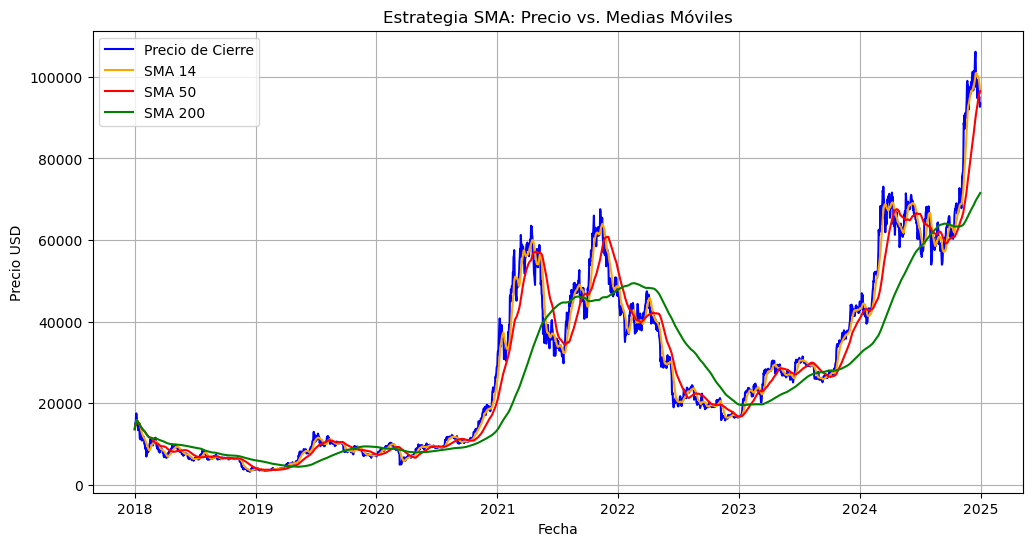

In [19]:
import matplotlib.pyplot as plt

# Pinto el gráfico
plt.figure(figsize=(12, 6))
plt.plot(btc_pandas["Date"], btc_pandas["Close"], label="Precio de Cierre", color="blue")
plt.plot(btc_pandas["Date"], btc_pandas["SMA_14"], label="SMA 14", color="orange")
plt.plot(btc_pandas["Date"], btc_pandas["SMA_50"], label="SMA 50", color="red")
plt.plot(btc_pandas["Date"], btc_pandas["SMA_200"], label="SMA 200", color="green")
plt.xlabel("Fecha")
plt.ylabel("Precio USD")
plt.title("Estrategia SMA: Precio vs. Medias Móviles")
plt.legend()
plt.grid()
plt.show()

## RSI para detectar sobrecompra/sobreventa

1. Cuando el RSI supera 70, Bitcoin podría estar sobrecomprado y es probable una corrección.
2. Cuando el RSI cae por debajo de 30, podría estar sobrevendido y es una posible oportunidad de compra.

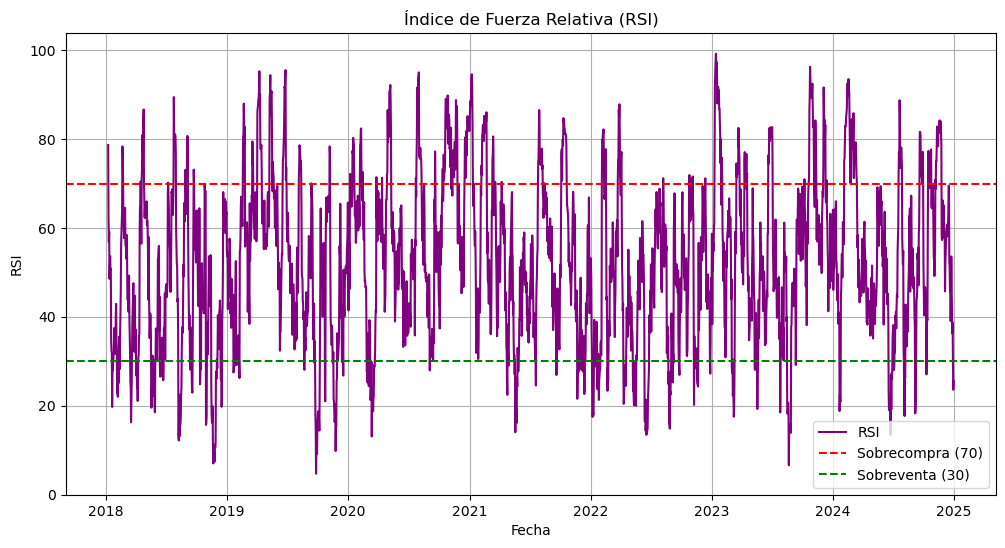

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(btc_pandas["Date"], btc_pandas["RSI"], label="RSI", color="purple")
plt.axhline(70, color="red", linestyle="--", label="Sobrecompra (70)")
plt.axhline(30, color="green", linestyle="--", label="Sobreventa (30)")
plt.xlabel("Fecha")
plt.ylabel("RSI")
plt.title("Índice de Fuerza Relativa (RSI)")
plt.legend()
plt.grid()
plt.show()

## Breakouts (rotura de soportes y resistencias)

1. Los puntos verdes indican cuando Bitcoin rompe una resistencia al alza (posible compra).
2. Los puntos rojos indican cuando Bitcoin rompe un soporte a la baja (posible venta).

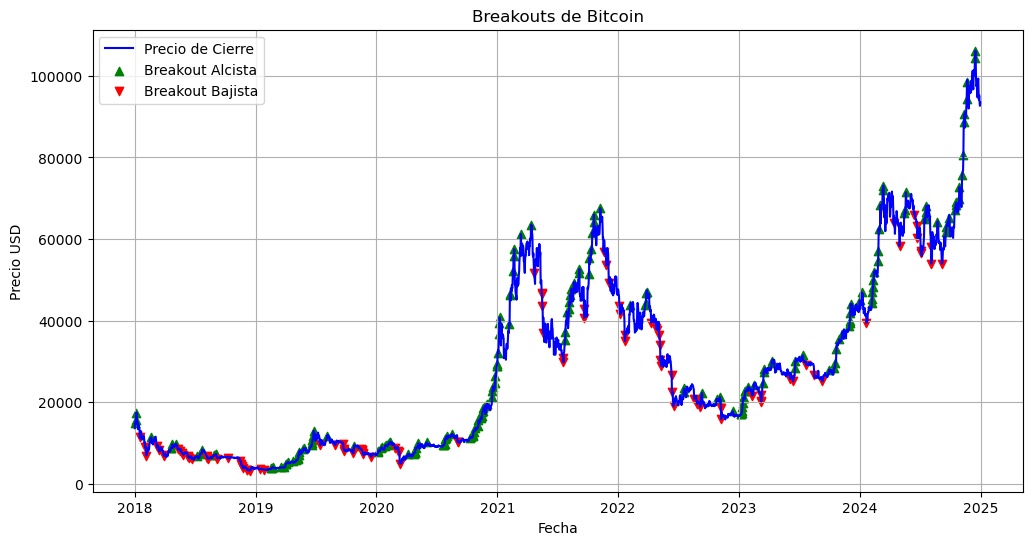

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(btc_pandas["Date"], btc_pandas["Close"], label="Precio de Cierre", color="blue")
plt.scatter(btc_pandas["Date"][btc_pandas["Breakout_Up"] == 1], 
            btc_pandas["Close"][btc_pandas["Breakout_Up"] == 1], 
            color="green", label="Breakout Alcista", marker="^")
plt.scatter(btc_pandas["Date"][btc_pandas["Breakout_Down"] == 1], 
            btc_pandas["Close"][btc_pandas["Breakout_Down"] == 1], 
            color="red", label="Breakout Bajista", marker="v")
plt.xlabel("Fecha")
plt.ylabel("Precio USD")
plt.title("Breakouts de Bitcoin")
plt.legend()
plt.grid()
plt.show()

# Backtesting de estrategias

## Estrategia SMA Crossover
✅ Comprar cuando la SMA 14 cruza por encima de la SMA 50 (señal alcista).
❌ Vender cuando la SMA 14 cruza por debajo de la SMA 50 (señal bajista).

In [17]:
# Leo los datos procesados
s3_path = "s3a://my-bucket/tables/btc_processed/"
df = spark.read.parquet(s3_path)

# Convierto a Pandas para graficar
btc_pandas = df.select("Date", "Close", "SMA_14", "SMA_50", "SMA_200").toPandas()

# Convierto la fecha a formato datetime
btc_pandas["Date"] = pd.to_datetime(btc_pandas["Date"])

In [18]:
from pyspark.sql.functions import lag, when, col

# Creo una ventana temporal ordenada por fecha
window_spec = Window().orderBy("Date")

# Obtengo el valor anterior de SMA_14 para detectar cruces
df = df.withColumn("SMA_14_Previa", lag("SMA_14", 1).over(window_spec))

# Identifico señales de compra y venta
df = df.withColumn("Buy_Signal", when((col("SMA_14_Previa") < col("SMA_50")) & (col("SMA_14") > col("SMA_50")), 1).otherwise(0))
df = df.withColumn("Sell_Signal", when((col("SMA_14_Previa") > col("SMA_50")) & (col("SMA_14") < col("SMA_50")), 1).otherwise(0))

# Verifico señales
df.select("Date", "Close", "SMA_14", "SMA_50", "Buy_Signal", "Sell_Signal").filter("Buy_Signal == 1 OR Sell_Signal == 1").show(10)

+----------+-----------------+------------------+------------------+----------+-----------+
|      Date|            Close|            SMA_14|            SMA_50|Buy_Signal|Sell_Signal|
+----------+-----------------+------------------+------------------+----------+-----------+
|2018-01-17|  11188.599609375| 14556.39990234375|14566.464613970587|         0|          1|
|2018-01-18|  11474.900390625|14261.807059151786|14394.711046006945|         0|          1|
|2018-01-19|  11607.400390625|13845.942801339286|14248.010485197368|         0|          1|
|2018-03-01|          10951.0|10531.635811941964|   10524.138671875|         1|          0|
|2018-03-16|   8338.349609375| 9700.517787388393|  9781.65763671875|         0|          1|
|2018-04-24|           9697.5| 8332.829973493304|  8190.59517578125|         1|          0|
|2018-05-23| 7557.81982421875| 8388.183558872768|  8446.07677734375|         0|          1|
|2018-07-21|  7419.2900390625| 6786.911411830357| 6751.544990234375|         1| 

In [23]:
import pandas as pd
from pyspark.sql.functions import pandas_udf, PandasUDFType, lit, col
from pyspark.sql.types import StructType, StructField, TimestampType, DoubleType, IntegerType
from pyspark.sql import Window
import time

# Defino el esquema de salida de la UDF
schema = StructType([
    StructField("Date", TimestampType()),
    StructField("Close", DoubleType()),
    StructField("Buy_Signal", IntegerType()),
    StructField("Sell_Signal", IntegerType()),
    StructField("Capital", DoubleType()),
    StructField("BTC_Holdings", DoubleType()),
    StructField("Portfolio_Value", DoubleType())
])

# Defino mi UDF
@pandas_udf(schema, functionType=PandasUDFType.GROUPED_MAP)
def simulate_sma_crossover(pdf: pd.DataFrame) -> pd.DataFrame:
    # Convierto la columna "Date" a datetime
    pdf["Date"] = pd.to_datetime(pdf["Date"])
    
    # Ordeno por fecha
    pdf = pdf.sort_values("Date").reset_index(drop=True)
    
    # Inicializo variables de estado
    capital = 10000.0  # Capital inicial en USD
    btc_holdings = 0.0  # BTC en cartera
    
    # Inicializo listas para almacenar los resultados
    capital_list = []
    btc_list = []
    port_list = []
    
    # Itero sobre las filas en orden
    for idx, row in pdf.iterrows():
        close = row["Close"]
        buy_signal = row["Buy_Signal"]
        sell_signal = row["Sell_Signal"]
        
        # Si hay señal de compra y no tenemos BTC, compramos con todo el capital que tenemos
        if buy_signal == 1 and btc_holdings == 0:
            btc_holdings = capital / close
            capital = 0.0
        
        # Si hay señal de venta y tenemos BTC, vendemos todo lo que tenemos
        if sell_signal == 1 and btc_holdings > 0:
            capital = btc_holdings * close
            btc_holdings = 0.0
        
        # Actualizo el valor total de la cartera
        portfolio_value = capital + (btc_holdings * close)
        
        capital_list.append(capital)
        btc_list.append(btc_holdings)
        port_list.append(portfolio_value)
    
    # Agrego las nuevas columnas al DataFrame
    pdf["Capital"] = capital_list
    pdf["BTC_Holdings"] = btc_list
    pdf["Portfolio_Value"] = port_list
    
    # Selecciono solo las columnas definidas en el esquema
    pdf = pdf[["Date", "Close", "Buy_Signal", "Sell_Signal", "Capital", "BTC_Holdings", "Portfolio_Value"]]
    return pdf

# Agrupo en un solo grupo (todas las filas) para procesar de forma secuencial
df = df.withColumn("group", lit(1))

start = time.perf_counter()
result_df = df.groupBy("group").apply(simulate_sma_crossover).drop("group")#.collect()
end = time.perf_counter()

print(f"Tiempo de ejecución con Spark (añadir el collect para ver el tiempo real): {end - start:.4f} segundos")

result_df.orderBy("Date").createOrReplaceTempView("result_sma")
result_df.orderBy("Date").show(100)

Tiempo de ejecución con Spark (añadir el collect para ver el tiempo real): 0.0234 segundos
+-------------------+----------------+----------+-----------+-----------------+------------------+------------------+
|               Date|           Close|Buy_Signal|Sell_Signal|          Capital|      BTC_Holdings|   Portfolio_Value|
+-------------------+----------------+----------+-----------+-----------------+------------------+------------------+
|2018-01-01 00:00:00|13657.2001953125|         0|          0|          10000.0|               0.0|           10000.0|
|2018-01-02 00:00:00| 14982.099609375|         0|          0|          10000.0|               0.0|           10000.0|
|2018-01-03 00:00:00|         15201.0|         0|          0|          10000.0|               0.0|           10000.0|
|2018-01-04 00:00:00|15599.2001953125|         0|          0|          10000.0|               0.0|           10000.0|
|2018-01-05 00:00:00|         17429.5|         0|          0|          10000.0|    

In [25]:
from pyspark.sql.functions import col

# Valor final de la cartera a partir del DataFrame resultante
final_value = result_df.orderBy(col("Date").desc()).select("Portfolio_Value").first()[0]
initial_capital = 10000.0
returns = (final_value - initial_capital) / initial_capital * 100

print(f"📊 Retorno final: ${final_value:.2f}")
print(f"📈 Retorno relativo: {returns:.2f}%")

📊 Retorno final: $91938.84
📈 Retorno relativo: 819.39%


In [26]:
from pyspark.sql.window import Window
from pyspark.sql.functions import max, col

# Defino una ventana que abarque desde el inicio hasta cada fila, ordenado por fecha
window_spec = Window().orderBy("Date").rowsBetween(Window.unboundedPreceding, 0)

# Calculo la máxima cartera alcanzada hasta cada fecha y el drawdown correspondiente
result_df = result_df.withColumn("Max_Portfolio", max("Portfolio_Value").over(window_spec))
result_df = result_df.withColumn("Drawdown", (col("Max_Portfolio") - col("Portfolio_Value")) / col("Max_Portfolio"))

# Obtengo el drawdown máximo (la mayor caída)
max_drawdown = result_df.agg({"Drawdown": "max"}).collect()[0][0]

print(f"📉 Máximo Drawdown: {max_drawdown * 100:.2f}%")

📉 Máximo Drawdown: 55.18%


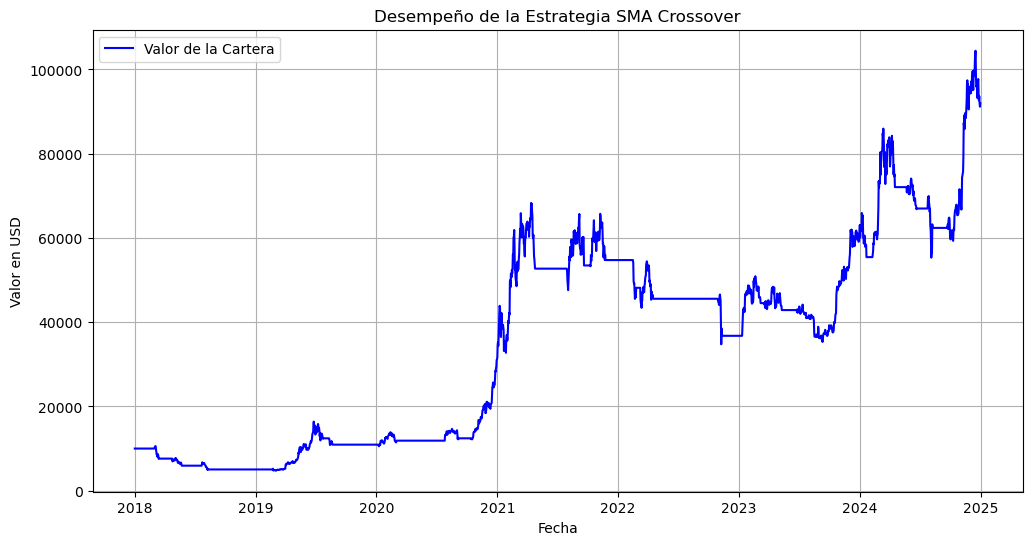

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

# Convierto a Pandas
btc_pandas = result_df.select("Date", "Portfolio_Value").toPandas()
btc_pandas["Date"] = pd.to_datetime(btc_pandas["Date"])

# Grafico el rendimiento de la cartera
plt.figure(figsize=(12, 6))
plt.plot(btc_pandas["Date"], btc_pandas["Portfolio_Value"], label="Valor de la Cartera", color="blue")
plt.xlabel("Fecha")
plt.ylabel("Valor en USD")
plt.title("Desempeño de la Estrategia SMA Crossover")
plt.legend()
plt.grid()
plt.show()

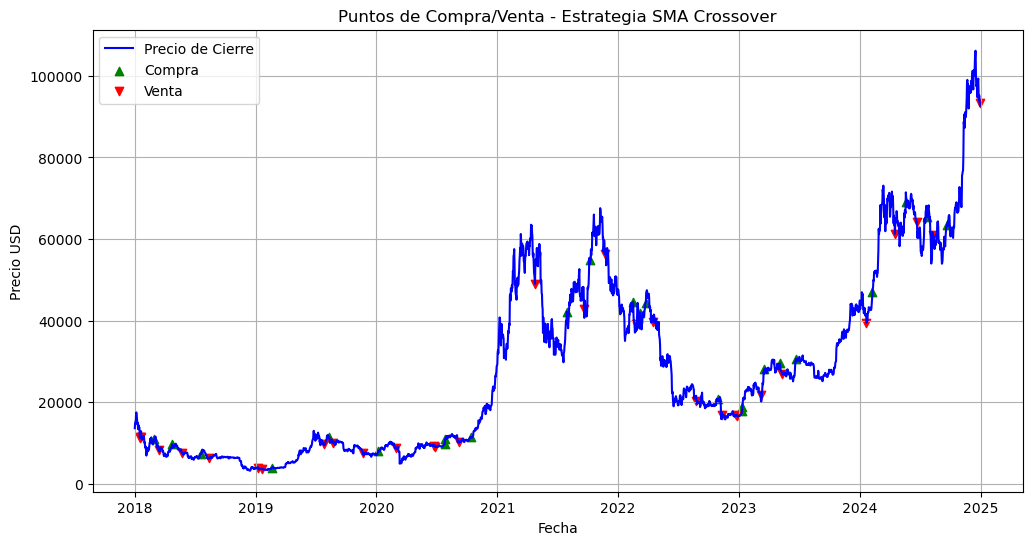

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

# Convierto las columnas necesarias a un DataFrame de Pandas para pintar el gráfico
btc_pandas = result_df.select("Date", "Close", "Buy_Signal", "Sell_Signal").toPandas()
btc_pandas["Date"] = pd.to_datetime(btc_pandas["Date"])

plt.figure(figsize=(12, 6))
plt.plot(btc_pandas["Date"], btc_pandas["Close"], label="Precio de Cierre", color="blue")
plt.scatter(btc_pandas["Date"][btc_pandas["Buy_Signal"] == 1], 
            btc_pandas["Close"][btc_pandas["Buy_Signal"] == 1], 
            color="green", label="Compra", marker="^")
plt.scatter(btc_pandas["Date"][btc_pandas["Sell_Signal"] == 1], 
            btc_pandas["Close"][btc_pandas["Sell_Signal"] == 1], 
            color="red", label="Venta", marker="v")
plt.xlabel("Fecha")
plt.ylabel("Precio USD")
plt.title("Puntos de Compra/Venta - Estrategia SMA Crossover")
plt.legend()
plt.grid()
plt.show()

## Estrategia RSI
✅ Comprar cuando el RSI cae por debajo de 30 (sobreventa, posible rebote alcista).
❌ Vender cuando el RSI supera 70 (sobrecompra, posible caída).

In [29]:
# Leo los datos procesados
s3_path = "s3a://my-bucket/tables/btc_processed/"
df = spark.read.parquet(s3_path)

# Convierto a Pandas para graficar
btc_pandas = df.select("Date", "Close", "SMA_14", "SMA_50", "SMA_200", "RSI", "Breakout_Up", "Breakout_Down").toPandas()

# Convierto la fecha a formato datetime
btc_pandas["Date"] = pd.to_datetime(btc_pandas["Date"])

In [30]:
import pandas as pd
from pyspark.sql.functions import pandas_udf, PandasUDFType, lit, col
from pyspark.sql.types import StructType, StructField, TimestampType, DoubleType, IntegerType
from pyspark.sql import Window
import matplotlib.pyplot as plt

# Defino el esquema de salida para la UDF (incluyendo columnas de resultados de la simulación)
schema_rsi = StructType([
    StructField("Date", TimestampType()),
    StructField("Close", DoubleType()),
    StructField("RSI", DoubleType()),
    StructField("Buy_Signal", IntegerType()),
    StructField("Sell_Signal", IntegerType()),
    StructField("Capital", DoubleType()),
    StructField("BTC_Holdings", DoubleType()),
    StructField("Portfolio_Value", DoubleType())
])

# Defino mi UDF
@pandas_udf(schema_rsi, functionType=PandasUDFType.GROUPED_MAP)
def simulate_rsi_strategy(pdf: pd.DataFrame) -> pd.DataFrame:
    # Me aseguro de que la columna "Date" sea datetime y ordeno por fecha
    pdf["Date"] = pd.to_datetime(pdf["Date"])
    pdf = pdf.sort_values("Date").reset_index(drop=True)
    
    # Inicializo variables de estado
    capital = 10000.0  # Capital inicial en USD
    btc_holdings = 0.0  # BTC en cartera
    
    # Inicializo listas para almacenar los resultados diarios
    capital_list = []
    btc_list = []
    port_list = []
    
    # Itero sobre cada fila (cada día)
    for idx, row in pdf.iterrows():
        close = row["Close"]
        # Aunque aquí también tenemos RSI, usaremos las señales que ya se han calculado:
        buy_signal = row["Buy_Signal"]
        sell_signal = row["Sell_Signal"]
        
        # Si hay señal de compra y no tenemos BTC, compramos con todo el capital que tenemos
        if buy_signal == 1 and btc_holdings == 0:
            btc_holdings = capital / close  # Convierto todo el capital a BTC
            capital = 0.0  # Se invierte todo, así que ya no queda capital en USD
        
        # Si hay señal de venta y tenemos BTC, vendemos todo lo que tenemos
        if sell_signal == 1 and btc_holdings > 0:
            capital = btc_holdings * close  # Convierto todo el BTC a USD
            btc_holdings = 0.0 # Se vende todo, así que ya no queda capital en BTC
        
        # Actualizo el valor total de la cartera: capital en USD + (BTC * precio)
        portfolio_value = capital + (btc_holdings * close)
        
        capital_list.append(capital)
        btc_list.append(btc_holdings)
        port_list.append(portfolio_value)
    
    # Agrego los resultados a las columnas del DataFrame
    pdf["Capital"] = capital_list
    pdf["BTC_Holdings"] = btc_list
    pdf["Portfolio_Value"] = port_list
    
    # Selecciono solo las columnas definidas en el esquema
    pdf = pdf[["Date", "Close", "RSI", "Buy_Signal", "Sell_Signal", "Capital", "BTC_Holdings", "Portfolio_Value"]]
    return pdf

# Agrupo todas las filas en un único grupo para que se procese secuencialmente:
df = df.withColumn("group", lit(1))
result_df_rsi = df.groupBy("group").apply(simulate_rsi_strategy).drop("group")

# Ordeno por fecha
result_df_rsi = result_df_rsi.orderBy("Date")
result_df_rsi.orderBy("Date").createOrReplaceTempView("result_rsi")

result_df_rsi.show(20)

/usr/local/spark/python/pyspark/sql/pandas/group_ops.py:104: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


+-------------------+----------------+------------------+----------+-----------+-------+------------------+-----------------+
|               Date|           Close|               RSI|Buy_Signal|Sell_Signal|Capital|      BTC_Holdings|  Portfolio_Value|
+-------------------+----------------+------------------+----------+-----------+-------+------------------+-----------------+
|2018-01-01 00:00:00|13657.2001953125|              NULL|         0|          0|10000.0|               0.0|          10000.0|
|2018-01-02 00:00:00| 14982.099609375|              NULL|         0|          0|10000.0|               0.0|          10000.0|
|2018-01-03 00:00:00|         15201.0|              NULL|         0|          0|10000.0|               0.0|          10000.0|
|2018-01-04 00:00:00|15599.2001953125|              NULL|         0|          0|10000.0|               0.0|          10000.0|
|2018-01-05 00:00:00|         17429.5|              NULL|         0|          0|10000.0|               0.0|          1

In [31]:
# Valor final de la cartera
from pyspark.sql.functions import col

final_value_rsi = result_df_rsi.orderBy(col("Date").desc()).select("Portfolio_Value").first()[0]
initial_capital = 10000.0
returns_rsi = (final_value_rsi - initial_capital) / initial_capital * 100


print(f"📊 Retorno final: ${final_value_rsi:.2f}")
print(f"📈 Retorno relativo: {returns_rsi:.2f}%")

📊 Retorno final: $3462.42
📈 Retorno relativo: -65.38%


In [32]:
from pyspark.sql.functions import max

df = result_df_rsi.withColumn("Max_Portfolio", max("Portfolio_Value").over(Window().orderBy("Date")))
df = df.withColumn("Drawdown", (col("Max_Portfolio") - col("Portfolio_Value")) / col("Max_Portfolio"))

max_drawdown = df.agg({"Drawdown": "max"}).collect()[0][0]

print(f"📉 Máximo Drawdown: {max_drawdown * 100:.2f}%")

📉 Máximo Drawdown: 86.24%


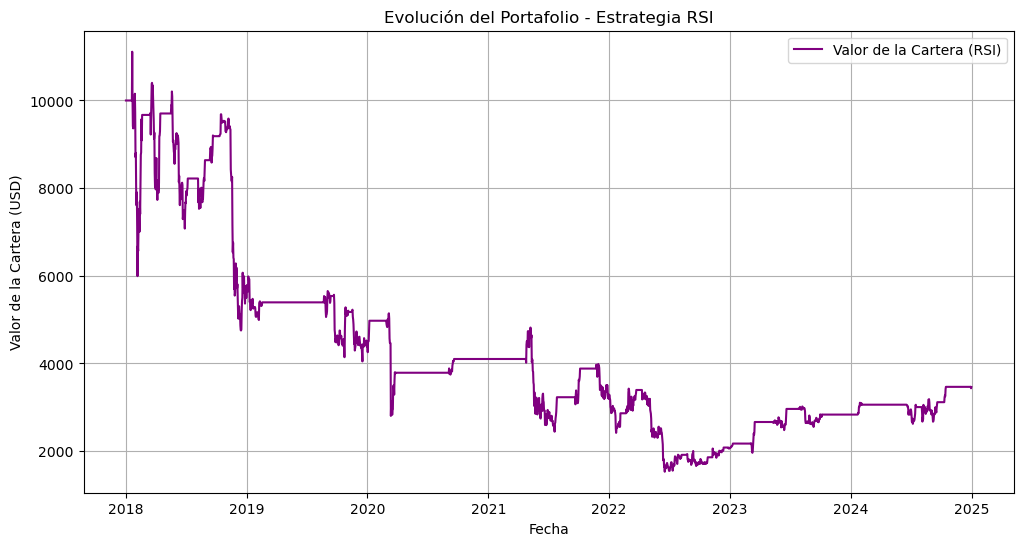

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

# Convierto a Pandas para graficar
rsi_pandas = result_df_rsi.select("Date", "Portfolio_Value").toPandas()
rsi_pandas["Date"] = pd.to_datetime(rsi_pandas["Date"])

plt.figure(figsize=(12, 6))
plt.plot(rsi_pandas["Date"], rsi_pandas["Portfolio_Value"], label="Valor de la Cartera (RSI)", color="purple")
plt.xlabel("Fecha")
plt.ylabel("Valor de la Cartera (USD)")
plt.title("Evolución del Portafolio - Estrategia RSI")
plt.legend()
plt.grid()
plt.show()

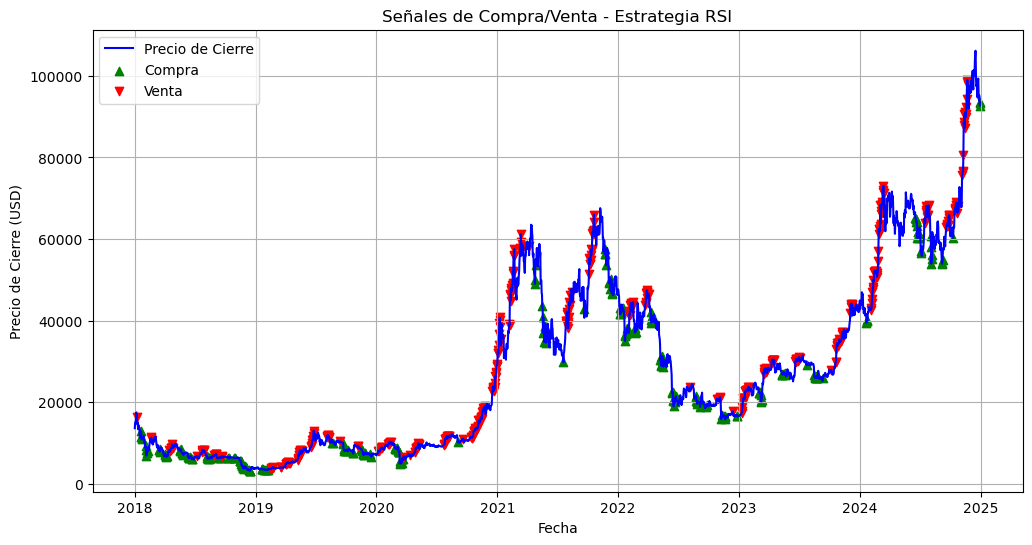

In [34]:
# Convierto las columnas relevantes a un DataFrame de Pandas para graficar

rsi_signals = result_df_rsi.select("Date", "Close", "Buy_Signal", "Sell_Signal").toPandas()
rsi_signals["Date"] = pd.to_datetime(rsi_signals["Date"])

plt.figure(figsize=(12, 6))
plt.plot(rsi_signals["Date"], rsi_signals["Close"], label="Precio de Cierre", color="blue")
plt.scatter(rsi_signals["Date"][rsi_signals["Buy_Signal"] == 1],
            rsi_signals["Close"][rsi_signals["Buy_Signal"] == 1],
            color="green", label="Compra", marker="^")
plt.scatter(rsi_signals["Date"][rsi_signals["Sell_Signal"] == 1],
            rsi_signals["Close"][rsi_signals["Sell_Signal"] == 1],
            color="red", label="Venta", marker="v")
plt.xlabel("Fecha")
plt.ylabel("Precio de Cierre (USD)")
plt.title("Señales de Compra/Venta - Estrategia RSI")
plt.legend()
plt.grid()
plt.show()

## Breakout trading
✅ Comprar cuando el precio rompe una resistencia (Breakout_Up = 1).
❌ Vender cuando el precio rompe un soporte (Breakout_Down = 1).

In [35]:
# Leo los datos procesados
s3_path = "s3a://my-bucket/tables/btc_processed/"
df = spark.read.parquet(s3_path)

# Convierto a Pandas para graficar
btc_pandas = df.select("Date", "Close", "SMA_14", "SMA_50", "SMA_200", "RSI", "Breakout_Up", "Breakout_Down").toPandas()

# Convierto la fecha a formato datetime
btc_pandas["Date"] = pd.to_datetime(btc_pandas["Date"])

In [36]:
import pandas as pd
from pyspark.sql.functions import pandas_udf, PandasUDFType, lit, col
from pyspark.sql.types import StructType, StructField, TimestampType, DoubleType, IntegerType
from pyspark.sql import Window

# Defino el esquema de salida de la UDF
schema_breakout = StructType([
    StructField("Date", TimestampType()),
    StructField("Close", DoubleType()),
    StructField("Breakout_Up", IntegerType()),
    StructField("Breakout_Down", IntegerType()),
    StructField("Capital", DoubleType()),
    StructField("BTC_Holdings", DoubleType()),
    StructField("Portfolio_Value", DoubleType())
])

# Defino mi UDF
@pandas_udf(schema_breakout, functionType=PandasUDFType.GROUPED_MAP)
def simulate_breakout_strategy(pdf: pd.DataFrame) -> pd.DataFrame:
    # Convierto "Date" a datetime y ordeno por fecha
    pdf["Date"] = pd.to_datetime(pdf["Date"])
    pdf = pdf.sort_values("Date").reset_index(drop=True)
    
    # Inicializo variables de estado
    capital = 10000.0   # Capital inicial en USD
    btc_holdings = 0.0   # BTC en cartera
    
    # Inicializo listas para almacenar resultados diarios
    capital_list = []
    btc_list = []
    portfolio_list = []
    
    # Itero sobre cada fila (cada día)
    for idx, row in pdf.iterrows():
        close = row["Close"]
        buy_signal = row["Breakout_Up"]      # señal de compra
        sell_signal = row["Breakout_Down"]     # señal de venta
        
        # Si hay señal de compra y no tenemos BTC, compramos con todo el capital que tenemos
        if buy_signal == 1 and btc_holdings == 0:
            btc_holdings = capital / close    # Convertimos todo el capital en BTC
            capital = 0.0
        # Si hay señal de venta y tenemos BTC, vendemos todo lo que tenemos
        if sell_signal == 1 and btc_holdings > 0:
            capital = btc_holdings * close    # Convertimos todo el BTC a USD
            btc_holdings = 0.0
        
        # El valor total de la cartera se actualiza con el precio del día
        portfolio_value = capital + (btc_holdings * close)
        
        capital_list.append(capital)
        btc_list.append(btc_holdings)
        portfolio_list.append(portfolio_value)
    
    # Agrego las nuevas columnas al DataFrame Pandas
    pdf["Capital"] = capital_list
    pdf["BTC_Holdings"] = btc_list
    pdf["Portfolio_Value"] = portfolio_list
    
    # Selecciono solo las columnas definidas en el esquema
    pdf = pdf[["Date", "Close", "Breakout_Up", "Breakout_Down", "Capital", "BTC_Holdings", "Portfolio_Value"]]
    return pdf

# Como df contiene las señales, agrupo todo en un único grupo para procesar secuencialmente:
df = df.withColumn("group", lit(1))
result_df_breakout = df.groupBy("group").apply(simulate_breakout_strategy).drop("group")
result_df_breakout = result_df_breakout.orderBy("Date")
result_df_breakout.orderBy("Date").createOrReplaceTempView("result_breakout")

result_df_breakout.show(20)

/usr/local/spark/python/pyspark/sql/pandas/group_ops.py:104: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


+-------------------+----------------+-----------+-------------+-----------------+------------------+------------------+
|               Date|           Close|Breakout_Up|Breakout_Down|          Capital|      BTC_Holdings|   Portfolio_Value|
+-------------------+----------------+-----------+-------------+-----------------+------------------+------------------+
|2018-01-01 00:00:00|13657.2001953125|          0|            0|          10000.0|               0.0|           10000.0|
|2018-01-02 00:00:00| 14982.099609375|          1|            0|              0.0|0.6674631901220662|           10000.0|
|2018-01-03 00:00:00|         15201.0|          0|            0|              0.0|0.6674631901220662|10146.107953045528|
|2018-01-04 00:00:00|15599.2001953125|          1|            0|              0.0|0.6674631901220662| 10411.89192571604|
|2018-01-05 00:00:00|         17429.5|          1|            0|              0.0|0.6674631901220662|11633.549672232553|
|2018-01-06 00:00:00|         17

In [37]:
# Valor final de la cartera
from pyspark.sql.functions import col, max as spark_max
from pyspark.sql.window import Window

final_value_breakout = result_df_breakout.orderBy(col("Date").desc()).select("Portfolio_Value").first()[0]
initial_capital = 10000.0
returns_breakout = (final_value_breakout - initial_capital) / initial_capital * 100

print(f"📊 Retorno final: ${final_value_breakout:.2f}")
print(f"📈 Retorno relativo: {returns_breakout:.2f}%")

📊 Retorno final: $171604.50
📈 Retorno relativo: 1616.04%


In [38]:
from pyspark.sql.functions import max

# Calculo el máximo drawdown
window_spec = Window().orderBy("Date").rowsBetween(Window.unboundedPreceding, 0)
result_df_breakout = result_df_breakout.withColumn("Max_Portfolio", spark_max("Portfolio_Value").over(window_spec))
result_df_breakout = result_df_breakout.withColumn("Drawdown", (col("Max_Portfolio") - col("Portfolio_Value")) / col("Max_Portfolio"))
max_drawdown_breakout = result_df_breakout.agg({"Drawdown": "max"}).collect()[0][0]

print(f"📉 Máximo Drawdown: {max_drawdown_breakout * 100:.2f}%")

📉 Máximo Drawdown: 57.22%


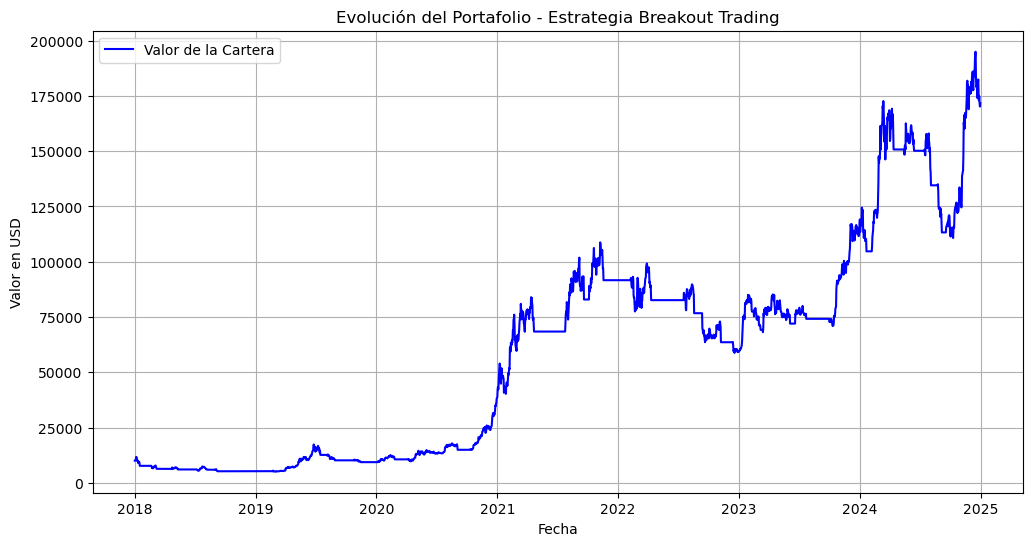

In [39]:
import matplotlib.pyplot as plt
import pandas as pd

# Convierto a Pandas para hacer el gráfico
breakout_pandas = result_df_breakout.select("Date", "Portfolio_Value").toPandas()
breakout_pandas["Date"] = pd.to_datetime(breakout_pandas["Date"])

plt.figure(figsize=(12, 6))
plt.plot(breakout_pandas["Date"], breakout_pandas["Portfolio_Value"], label="Valor de la Cartera", color="blue")
plt.xlabel("Fecha")
plt.ylabel("Valor en USD")
plt.title("Evolución del Portafolio - Estrategia Breakout Trading")
plt.legend()
plt.grid()
plt.show()

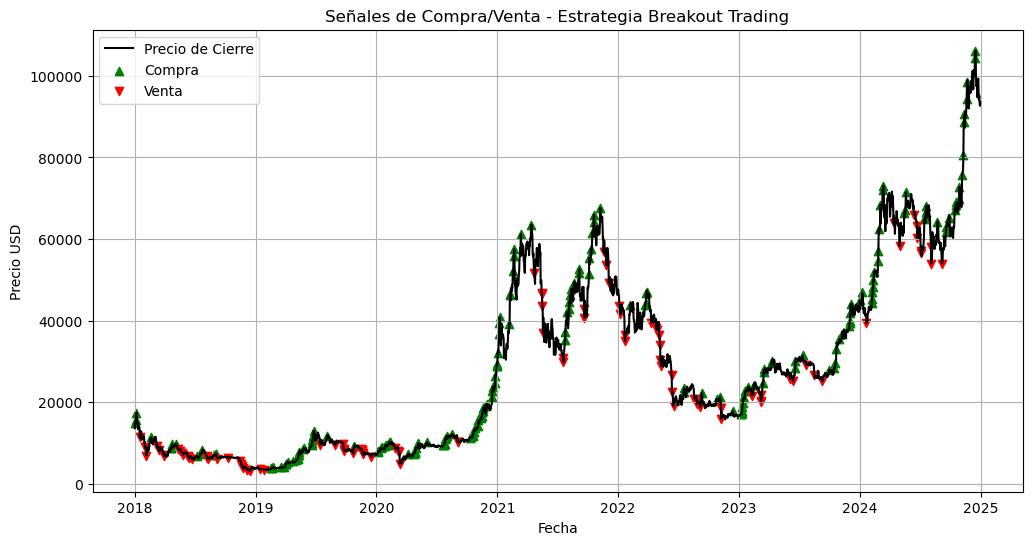

In [40]:
# Convierto las columnas relevantes a un DataFrame de Pandas

breakout_signals = result_df_breakout.select("Date", "Close", "Breakout_Up", "Breakout_Down").toPandas()
breakout_signals["Date"] = pd.to_datetime(breakout_signals["Date"])

plt.figure(figsize=(12, 6))
plt.plot(breakout_signals["Date"], breakout_signals["Close"], label="Precio de Cierre", color="black")
plt.scatter(breakout_signals["Date"][breakout_signals["Breakout_Up"] == 1],
            breakout_signals["Close"][breakout_signals["Breakout_Up"] == 1],
            color="green", label="Compra", marker="^")
plt.scatter(breakout_signals["Date"][breakout_signals["Breakout_Down"] == 1],
            breakout_signals["Close"][breakout_signals["Breakout_Down"] == 1],
            color="red", label="Venta", marker="v")
plt.xlabel("Fecha")
plt.ylabel("Precio USD")
plt.title("Señales de Compra/Venta - Estrategia Breakout Trading")
plt.legend()
plt.grid()
plt.show()

## DCA
✅ Se comprará $100 cada semana, sin importar el precio.
✅ No hay ventas; simplemente acumulamos Bitcoin con el tiempo.
✅ Evaluaremos el valor total de la inversión al final del período.

In [41]:
# Leo los datos procesados
s3_path = "s3a://my-bucket/tables/btc_processed/"
df = spark.read.parquet(s3_path)

# Convierto a Pandas para graficar
btc_pandas = df.select("Date", "Close", "SMA_14", "SMA_50", "SMA_200", "RSI", "Breakout_Up", "Breakout_Down").toPandas()

# Convierto la fecha a formato datetime
btc_pandas["Date"] = pd.to_datetime(btc_pandas["Date"])

In [42]:
from pyspark.sql.types import StructType, StructField, TimestampType, DoubleType
from pyspark.sql.functions import pandas_udf, PandasUDFType, lit
import pandas as pd

# Defino el esquema de salida de la UDF
schema_dca = StructType([
    StructField("Date", TimestampType()),
    StructField("Close", DoubleType()),
    StructField("Invested", DoubleType()),      # Total invertido hasta ese día
    StructField("BTC_Holdings", DoubleType()),  # Total de BTC acumulado
    StructField("Portfolio_Value", DoubleType())# Valor de la cartera (BTC acumulado * precio actual)
])

# Defino la UDF
@pandas_udf(schema_dca, functionType=PandasUDFType.GROUPED_MAP)
def simulate_dca_strategy(pdf: pd.DataFrame) -> pd.DataFrame:
    # Convierto la columna "Date" a datetime y ordeno por fecha
    pdf["Date"] = pd.to_datetime(pdf["Date"])
    pdf = pdf.sort_values("Date").reset_index(drop=True)
    
    fixed_investment = 119.0  # Cantidad fijo a invertir cada mes (10000 euros entre 84 meses (7 años), para equiparar a las otras)
    total_invested = 0.0      # Suma acumulada de la inversión
    total_BTC = 0.0         # BTC acumulado
    
    invested_list = []
    btc_list = []
    portfolio_list = []
    
    previous_month = None
    
    # Itero sobre cada fila (cada día)
    for idx, row in pdf.iterrows():
        close = row["Close"]
        current_month = row["Date"].month  # Obtenemos el mes actual
        
        # Si es el primer registro o cambia el mes, se realiza la inversión
        if previous_month is None or current_month != previous_month:
            total_invested += fixed_investment
            btc_bought = fixed_investment / close
            total_BTC += btc_bought
        
        # Actualizamos el mes previo
        previous_month = current_month
        
        # El valor de la cartera se actualiza según el precio de cierre del día
        portfolio_value = total_BTC * close
        
        invested_list.append(total_invested)
        btc_list.append(total_BTC)
        portfolio_list.append(portfolio_value)
    
    pdf["Invested"] = invested_list
    pdf["BTC_Holdings"] = btc_list
    pdf["Portfolio_Value"] = portfolio_list
    
    # Selecciono solo las columnas definidas en el esquema
    pdf = pdf[["Date", "Close", "Invested", "BTC_Holdings", "Portfolio_Value"]]
    return pdf

# Agrego una columna "group" para agrupar todas las filas en un único grupo
df = df.withColumn("group", lit(1))

# Aplico la UDF para simular la estrategia DCA de forma secuencial
result_df_dca = df.groupBy("group").apply(simulate_dca_strategy).drop("group")
result_df_dca.orderBy("Date").createOrReplaceTempView("result_dca")

# Ordenar el resultado por fecha
result_df_dca = result_df_dca.orderBy("Date")
result_df_dca.show(20)

/usr/local/spark/python/pyspark/sql/pandas/group_ops.py:104: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


+-------------------+----------------+--------+--------------------+------------------+
|               Date|           Close|Invested|        BTC_Holdings|   Portfolio_Value|
+-------------------+----------------+--------+--------------------+------------------+
|2018-01-01 00:00:00|13657.2001953125|   119.0|0.008713352539186169|119.00000000000001|
|2018-01-02 00:00:00| 14982.099609375|   119.0|0.008713352539186169|130.54431567368775|
|2018-01-03 00:00:00|         15201.0|   119.0|0.008713352539186169|132.45167194816895|
|2018-01-04 00:00:00|15599.2001953125|   119.0|0.008713352539186169|135.92133063109955|
|2018-01-05 00:00:00|         17429.5|   119.0|0.008713352539186169| 151.8693780817453|
|2018-01-06 00:00:00|         17527.0|   119.0|0.008713352539186169|152.71892995431597|
|2018-01-07 00:00:00| 16477.599609375|   119.0|0.008713352539186169|143.57513439604068|
|2018-01-08 00:00:00| 15170.099609375|   119.0|0.008713352539186169|132.18242595105477|
|2018-01-09 00:00:00| 14595.4003

In [43]:
from pyspark.sql.functions import col

# Valor final de la cartera
final_value_dca = result_df_dca.orderBy(col("Date").desc()).select("Portfolio_Value").first()[0]

# Total invertido (lo obtenemos del último registro de la columna "Invested")
total_invested = result_df_dca.orderBy(col("Date").desc()).select("Invested").first()[0]

returns_dca = (final_value_dca - total_invested) / total_invested * 100

print(f"📊 Valor final de la inversión: ${final_value_dca:.2f}")
print(f"DCA Strategy - Total invertido: ${total_invested:.2f}")
print(f"📈 Rentabilidad total: {returns_dca:.2f}%")

📊 Valor final de la inversión: $69328.89
DCA Strategy - Total invertido: $9996.00
📈 Rentabilidad total: 593.57%


In [44]:
import pandas as pd

# Convierto el DataFrame resultante a Pandas
dca_pd = result_df_dca.toPandas()
dca_pd["Date"] = pd.to_datetime(dca_pd["Date"])
dca_pd = dca_pd.sort_values("Date").reset_index(drop=True)

# Calculo el máximo acumulado (running max) de la columna Portfolio_Value
dca_pd["Running_Max"] = dca_pd["Portfolio_Value"].cummax()

# Calculo el drawdown diario: (Running_Max - Portfolio_Value) / Running_Max
dca_pd["Drawdown"] = (dca_pd["Running_Max"] - dca_pd["Portfolio_Value"]) / dca_pd["Running_Max"]

# Obtengo el máximo drawdown (la mayor caída)
max_drawdown = dca_pd["Drawdown"].max()
print(f"📉 Máximo Drawdown:  {max_drawdown*100:.2f}%")

📉 Máximo Drawdown:  74.75%


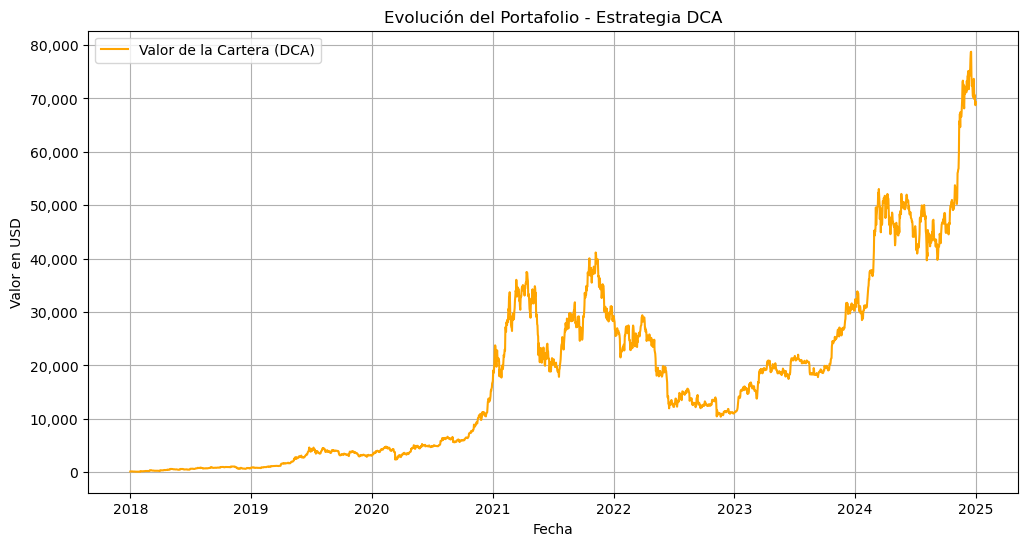

In [45]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker

# Convierto a Pandas para graficar
dca_pandas = result_df_dca.select("Date", "Portfolio_Value").toPandas()
dca_pandas["Date"] = pd.to_datetime(dca_pandas["Date"])

plt.figure(figsize=(12, 6))
plt.plot(dca_pandas["Date"], dca_pandas["Portfolio_Value"], label="Valor de la Cartera (DCA)", color="orange")
plt.xlabel("Fecha")
plt.ylabel("Valor en USD")
plt.title("Evolución del Portafolio - Estrategia DCA")

# Aplico formato para evitar la notación científica en el eje Y
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ",")))  # Formato con separador de miles

plt.legend()
plt.grid()
plt.show()

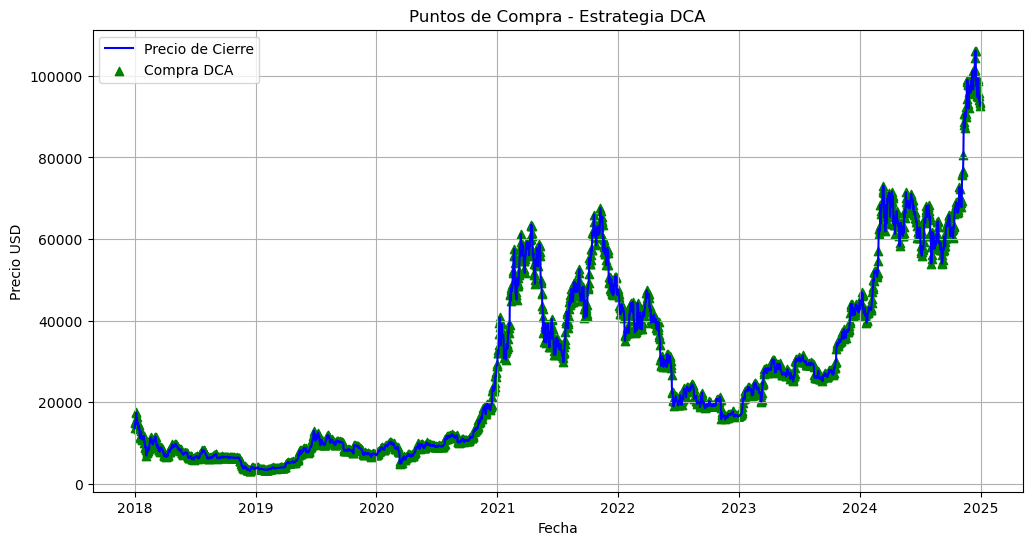

In [46]:
# Convierto a Pandas las columnas necesarias
dca_signals = result_df_dca.select("Date", "Close").toPandas()
dca_signals["Date"] = pd.to_datetime(dca_signals["Date"])

plt.figure(figsize=(12, 6))
plt.plot(dca_signals["Date"], dca_signals["Close"], label="Precio de Cierre", color="blue")
# En DCA, cada día se compra; por lo tanto, puedes marcar cada día con un marcador
plt.scatter(dca_signals["Date"], dca_signals["Close"], color="green", label="Compra DCA", marker="^")
plt.xlabel("Fecha")
plt.ylabel("Precio USD")
plt.title("Puntos de Compra - Estrategia DCA")
plt.legend()
plt.grid()
plt.show()

# Comparación de estrategias

In [47]:
from pyspark.sql.functions import col

# Cargo las tablas temporales anteriores con los resultados de cada estrategia
result_sma = spark.table("result_sma")
result_rsi = spark.table("result_rsi")
result_breakout = spark.table("result_breakout")
result_dca = spark.table("result_dca")

sma_df = result_sma.select("Date", col("Portfolio_Value").alias("Portfolio_SMA"))
rsi_df = result_rsi.select("Date", col("Portfolio_Value").alias("Portfolio_RSI"))
breakout_df = result_breakout.select("Date", col("Portfolio_Value").alias("Portfolio_Breakout"))
dca_df = result_dca.select("Date", col("Portfolio_Value").alias("Portfolio_DCA"))

# Hago un join para tener todos los resultados de las diferentes estrategias en un mismo df para poder comparar
joined_df = sma_df.join(rsi_df, on="Date", how="outer") \
                  .join(breakout_df, on="Date", how="outer") \
                  .join(dca_df, on="Date", how="outer")

# Ordeno por fecha
joined_df = joined_df.orderBy("Date")
joined_df.sort(col("Date").desc()).show(20)

+-------------------+------------------+------------------+------------------+-----------------+
|               Date|     Portfolio_SMA|     Portfolio_RSI|Portfolio_Breakout|    Portfolio_DCA|
+-------------------+------------------+------------------+------------------+-----------------+
|2024-12-31 00:00:00| 91938.84165544216| 3462.418534152677|171604.49567262706|69328.89189560236|
|2024-12-30 00:00:00| 91165.38743714709|3433.2902335071262|170160.83792507992|68745.64848160182|
|2024-12-29 00:00:00| 92038.25358996731| 3466.162389507151|171790.04874879008|69403.85606893465|
|2024-12-28 00:00:00| 93645.89625304795| 3466.162389507151|174790.72510551053|70616.14113135883|
|2024-12-27 00:00:00| 92662.76288370197| 3466.162389507151| 172955.6997453062| 69874.7836609462|
|2024-12-26 00:00:00| 94267.40727484193| 3466.162389507151| 175950.7798063261|71084.80779787355|
|2024-12-25 00:00:00| 97715.19705818706| 3466.162389507151|  182386.103727129|73684.70399913429|
|2024-12-24 00:00:00| 97102.03

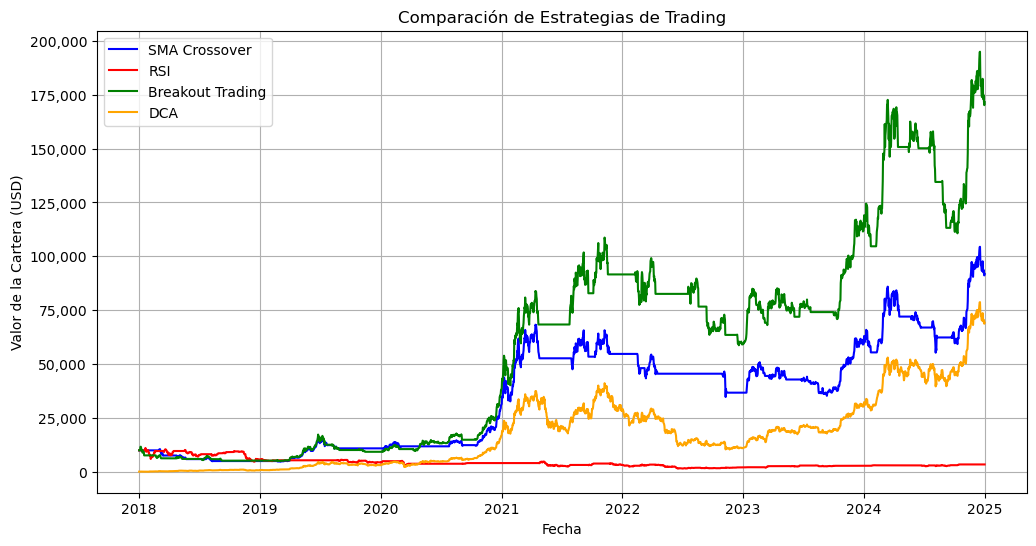

In [48]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker

# Convierto a Pandas
joined_pd = joined_df.toPandas()
joined_pd["Date"] = pd.to_datetime(joined_pd["Date"])

plt.figure(figsize=(12, 6))
plt.plot(joined_pd["Date"], joined_pd["Portfolio_SMA"], label="SMA Crossover", color="blue")
plt.plot(joined_pd["Date"], joined_pd["Portfolio_RSI"], label="RSI", color="red")
plt.plot(joined_pd["Date"], joined_pd["Portfolio_Breakout"], label="Breakout Trading", color="green")
plt.plot(joined_pd["Date"], joined_pd["Portfolio_DCA"], label="DCA", color="orange")
plt.xlabel("Fecha")
plt.ylabel("Valor de la Cartera (USD)")
plt.title("Comparación de Estrategias de Trading")

# Aplico formato para eliminar notación científica en el eje Y
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ",")))  # Formato con separador de miles

plt.legend()
plt.grid()
plt.show()

Basándome en datos históricos y en experiencias de backtesting, la estrategia de DCA (dollar-cost averaging) consistente (por ejemplo, comprando sistemáticamente el primer día de cada mes) suele superar a las estrategias que intentan “cronometrar” el mercado, como usar señales de RSI o cruces de SMA.

Además de esto, DCA ofrece:

- Consistencia y simplicidad: Comprar en fechas fijas elimina la incertidumbre de tratar de predecir picos y caídas.
- Menor riesgo de perder oportunidades: Los intentos de afinar la entrada con RSI u otros indicadores a menudo provocan que se pierda parte del crecimiento a largo plazo, como se observó en algunos backtests (por ejemplo, el DCA basado en RSI mostró resultados peores que el DCA simple). 
- Aprovechar la alta volatilidad de Bitcoin: Dado que Bitcoin tiene un crecimiento sostenido a largo plazo, el método DCA permite beneficiarse de las caídas sin preocuparse por el “timing” perfecto.

Otras estrategias:

- Breakout Trading: Puede capturar movimientos fuertes, pero es más arriesgado y requiere un monitoreo activo, lo que complica su aplicación en un mercado tan volátil.
- SMA Crossover: Al ser indicadores de tendencia, suelen reaccionar con retraso, lo que podría provocar entradas y salidas tardías.
- RSI: Si bien es útil para detectar condiciones de sobrecompra o sobreventa, en la práctica, utilizar el RSI para disparar compras en Bitcoin históricamente ha mostrado rendimientos inferiores a la simple inversión periódica, como se observa en los gráficos anteriores.

En resumen, para un inversor a largo plazo, una estrategia de DCA consistente (especialmente en momentos fijos como el primer día del mes) tiende a ser la opción más robusta, mientras que las estrategias basadas en indicadores técnicos pueden funcionar en ciertos entornos, pero generalmente presentan mayores complicaciones y riesgos.

In [49]:
import pandas as pd

# Convierto a Pandas y me aseguro de que la columna Date es datetime
joined_pd = joined_df.toPandas()
joined_pd["Date"] = pd.to_datetime(joined_pd["Date"])
joined_pd = joined_pd.sort_values("Date").reset_index(drop=True)

joined_pd.columns

Index(['Date', 'Portfolio_SMA', 'Portfolio_RSI', 'Portfolio_Breakout',
       'Portfolio_DCA'],
      dtype='object')

In [50]:
import numpy as np

# Cálculo del riesgo, en especifico de la volatilidad y del ratio de sharpe.
# Un ratio de Sharpe más alto indica que, por cada unidad de riesgo asumido, se obtiene un rendimiento mayor, 
# lo que se considera favorable. Es una herramienta muy útil para comparar diferentes inversiones o estrategias, 
# ya que permite evaluar no solo la rentabilidad absoluta, sino también la eficiencia en relación con el riesgo.

def calc_volatility_and_sharpe(returns, trading_days=254):
    vol_daily = returns.std()
    vol_annual = vol_daily * np.sqrt(trading_days)
    avg_return_daily = returns.mean()
    sharpe_ratio = (avg_return_daily / vol_daily) * np.sqrt(trading_days) if vol_daily != 0 else np.nan
    return vol_annual, sharpe_ratio

vol_sma, sharpe_sma = calc_volatility_and_sharpe(joined_pd["Portfolio_SMA"].dropna())
vol_rsi, sharpe_rsi = calc_volatility_and_sharpe(joined_pd["Portfolio_RSI"].dropna())
vol_breakout, sharpe_breakout = calc_volatility_and_sharpe(joined_pd["Portfolio_Breakout"].dropna())
vol_dca, sharpe_dca = calc_volatility_and_sharpe(joined_pd["Portfolio_DCA"].dropna())


print("⚠️ Volatilidad anualizada y Ratio de Sharpe:")
print(f"SMA: {vol_sma:.2%}, Sharpe: {sharpe_sma:.2f}")
print(f"RSI: {vol_rsi:.2%}, Sharpe: {sharpe_rsi:.2f}")
print(f"Breakout: {vol_breakout:.2%}, Sharpe: {sharpe_breakout:.2f}")
print(f"DCA: {vol_dca:.2%}, Sharpe: {sharpe_dca:.2f}")

⚠️ Volatilidad anualizada y Ratio de Sharpe:
SMA: 38525288.13%, Sharpe: 23.17
RSI: 3308220.80%, Sharpe: 32.36
Breakout: 77326232.34%, Sharpe: 19.26
DCA: 26561264.03%, Sharpe: 16.93


Una volatilidad de estos niveles es extraordinariamente alta. 

En términos generales, la volatilidad mide la variabilidad o dispersión del precio de un activo en un período determinado. Una cifra tan elevada implica:

- Movimientos extremos: El activo experimenta cambios de precio extremadamente grandes en periodos muy cortos, lo que hace casi imposible predecir su comportamiento.
- Alto riesgo: Con fluctuaciones tan drásticas, invertir en ese activo conlleva un riesgo muy alto, ya que el valor puede variar drásticamente en poco tiempo.


In [51]:
# Calculo ahora (para que quede centralizado, aunque ya lo he hecho antes para cada estrategia) el
# máximo drawdown para cada una de las estrategias con el fin de comprender el riesgo de cada una

def max_drawdown(portfolio_values):
    running_max = portfolio_values.cummax()
    drawdown = (running_max - portfolio_values) / running_max
    return drawdown.max()

drawdown_sma = max_drawdown(joined_pd["Portfolio_SMA"])
drawdown_rsi = max_drawdown(joined_pd["Portfolio_RSI"])
drawdown_breakout = max_drawdown(joined_pd["Portfolio_Breakout"])
drawdown_dca = max_drawdown(joined_pd["Portfolio_DCA"])

print("⚠️ Máximo Drawdown:")
print(f"SMA: {drawdown_sma:.2%}")
print(f"RSI: {drawdown_rsi:.2%}")
print(f"Breakout: {drawdown_breakout:.2%}")
print(f"DCA: {drawdown_dca:.2%}")


⚠️ Máximo Drawdown:
SMA: 55.18%
RSI: 86.24%
Breakout: 57.22%
DCA: 74.75%


In [2]:
spark.stop()